* only SAN/AVN cells
* only New data

## Import modules

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scrublet as scr
import session_info

In [3]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
session_info.show()

## Read in anndata

In [4]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/QC/multiome_RNA_adult_new-SAN-AVN_prefilter.h5ad')
adata

AnnData object with n_obs × n_vars = 146652 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expression-5', 'ambient_expression-6', 'ambient_expression-7', 'ambient_expression-8', 'ambient_expression-9'
    obsm: 'latent_gene_encoding'

In [5]:
adata.obs['combinedID'].value_counts()

HCAHeartST13180617_HCAHeartST13177114    16625
HCAHeartST13180615_HCAHeartST13177112    16497
HCAHeartST13189996_HCAHeartST13188801    15965
HCAHeartST13180616_HCAHeartST13177113    12300
HCAHeartST13180618_HCAHeartST13177115    10480
HCAHeartST13189997_HCAHeartST13188802    10159
HCAHeartST13189995_HCAHeartST13188800     9365
HCAHeartST13180619_HCAHeartST13177116     9001
HCAHeartST13168796_HCAHeartST13167740     8619
HCAHeartST13146207_HCAHeartST13129140     7593
HCAHeartST13146204_HCAHeartST13129137     6206
HCAHeartST13146205_HCAHeartST13129138     5833
HCAHeartST13146206_HCAHeartST13129139     4770
HCAHeartST13146208_HCAHeartST13129141     4392
HCAHeartST13146202_HCAHeartST13129135     4286
HCAHeartST13146203_HCAHeartST13129136     3515
HCAHeartST13146201_HCAHeartST13129134     1046
Name: combinedID, dtype: int64

## Remove doublets

<AxesSubplot:>

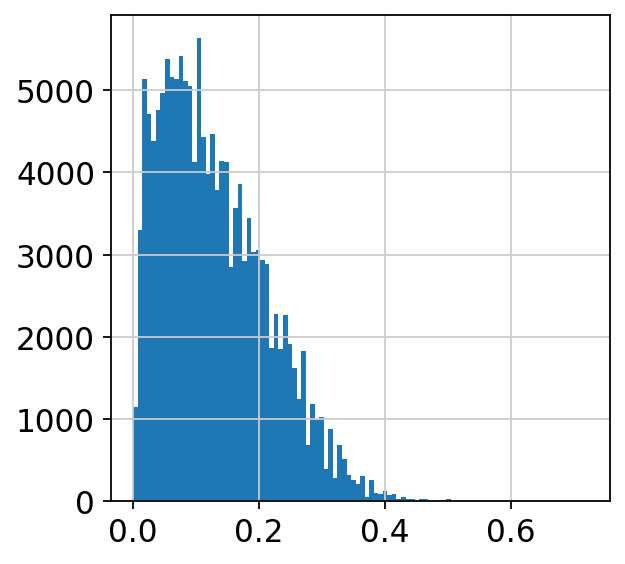

In [6]:
adata.obs['scrublet_score'].hist(bins=100)

In [7]:
# set threshold (arbitrary)
dbl_score_thresh=0.3

prop = np.sum(adata.obs['scrublet_score']>=dbl_score_thresh)/len(adata)
print(f'proportion of doublets: {prop}')

proportion of doublets: 0.03813790469956087


In [8]:
# Remove doublets
adata = adata[adata.obs['scrublet_score']<dbl_score_thresh]
adata

View of AnnData object with n_obs × n_vars = 141059 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expression-5', 'ambient_expression-6', 'ambient_expression-7', 'ambient_expression-8', 'ambient_expression-9'
    obsm: 'latent_gene_encoding'

## Remove low quality cells

In [9]:
sc.pp.filter_cells(adata, min_genes=200, inplace=True)
sc.pp.filter_cells(adata, min_counts=500, inplace=True)
adata.shape

filtered out 5441 cells that have less than 200 genes expressed
Trying to set attribute `.obs` of view, copying.
filtered out 7630 cells that have less than 500 counts


(127988, 36601)

In [10]:
adata.obs['combinedID'].value_counts()

HCAHeartST13189996_HCAHeartST13188801    14067
HCAHeartST13180615_HCAHeartST13177112    13864
HCAHeartST13180617_HCAHeartST13177114    13638
HCAHeartST13180616_HCAHeartST13177113     9956
HCAHeartST13189997_HCAHeartST13188802     8893
HCAHeartST13180618_HCAHeartST13177115     8481
HCAHeartST13168796_HCAHeartST13167740     8150
HCAHeartST13189995_HCAHeartST13188800     7672
HCAHeartST13146207_HCAHeartST13129140     7378
HCAHeartST13180619_HCAHeartST13177116     7238
HCAHeartST13146204_HCAHeartST13129137     6024
HCAHeartST13146205_HCAHeartST13129138     5443
HCAHeartST13146206_HCAHeartST13129139     4432
HCAHeartST13146208_HCAHeartST13129141     4246
HCAHeartST13146202_HCAHeartST13129135     4171
HCAHeartST13146203_HCAHeartST13129136     3411
HCAHeartST13146201_HCAHeartST13129134      924
Name: combinedID, dtype: int64

## Compute QC stats

In [11]:
adata.var['mt'] = adata.var['gene_name'].str.startswith(('MT-'))  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var['gene_name'].str.startswith('RPS','RPL')  # annotate the group of ribosomal genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

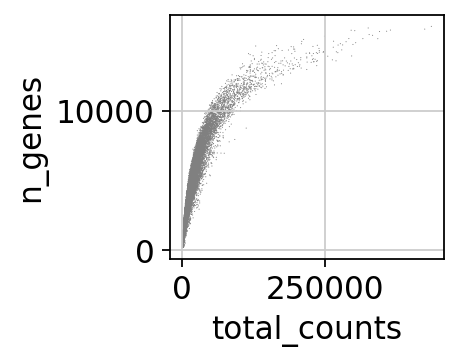

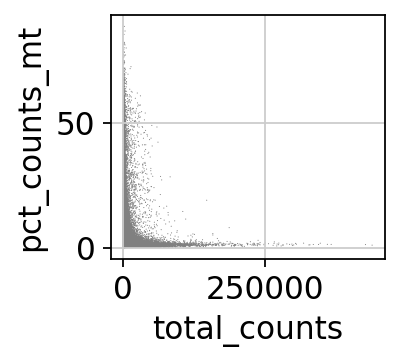

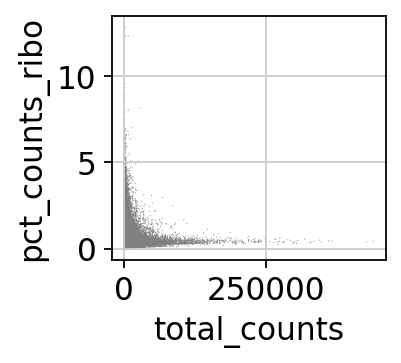

In [12]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='total_counts', y='n_genes')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo')

In [13]:
adata.shape

(127988, 36601)

## Remove cells exceeding the ribo/mito threshold

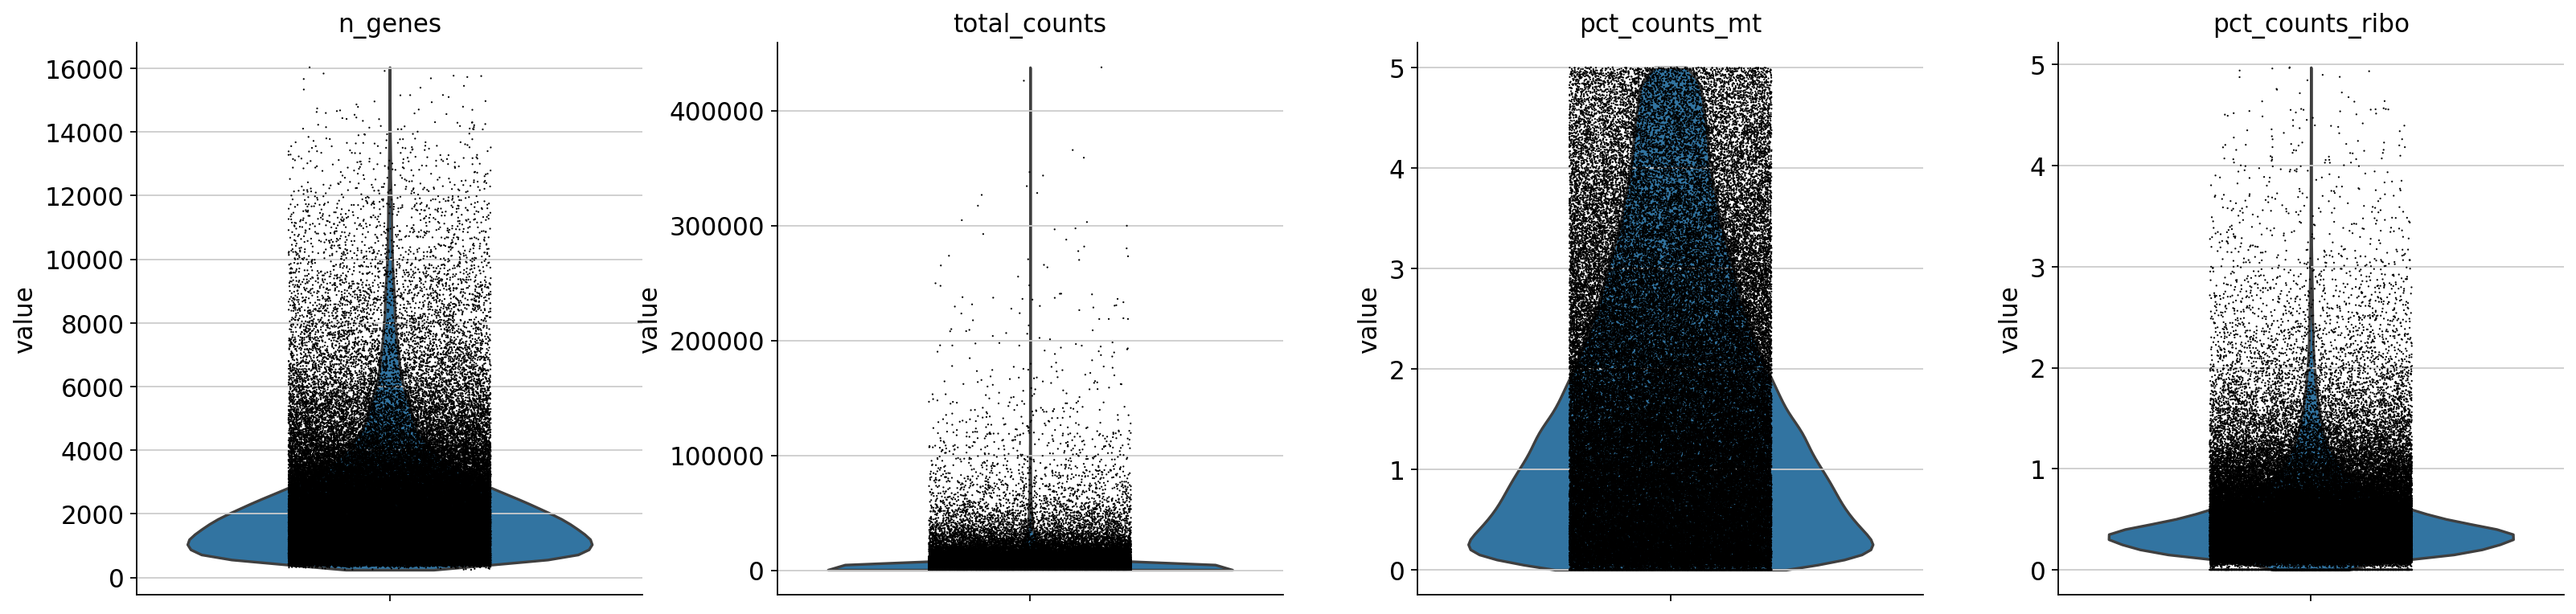

In [14]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['pct_counts_mt'] < 5, :]
adata = adata[adata.obs['pct_counts_ribo'] < 5, :]
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter = 0.2, multi_panel = True)

In [15]:
adata.obs['combinedID'].value_counts()

HCAHeartST13189996_HCAHeartST13188801    12950
HCAHeartST13189997_HCAHeartST13188802     8270
HCAHeartST13180615_HCAHeartST13177112     7335
HCAHeartST13180617_HCAHeartST13177114     7266
HCAHeartST13146207_HCAHeartST13129140     6837
HCAHeartST13180618_HCAHeartST13177115     6679
HCAHeartST13168796_HCAHeartST13167740     6310
HCAHeartST13180619_HCAHeartST13177116     5710
HCAHeartST13146204_HCAHeartST13129137     5544
HCAHeartST13180616_HCAHeartST13177113     5269
HCAHeartST13146205_HCAHeartST13129138     5009
HCAHeartST13146206_HCAHeartST13129139     4121
HCAHeartST13146202_HCAHeartST13129135     4079
HCAHeartST13146208_HCAHeartST13129141     3918
HCAHeartST13146203_HCAHeartST13129136     3324
HCAHeartST13189995_HCAHeartST13188800     1789
HCAHeartST13146201_HCAHeartST13129134      554
Name: combinedID, dtype: int64

## Save

In [16]:
adata.write('/nfs/team205/heart/anndata_objects/8regions/QC/multiome_RNA_adult_new-SAN-AVN.h5ad')
adata

View of AnnData object with n_obs × n_vars = 94964 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expression-5', 'ambient_expression-6', 'ambient_expression-7', 'ambient_expression-8', 'ambient_expression-9', 'mt', 'ribo', 'n_cells

In [17]:
adata.obs['donor'].value_counts()

AH2     32259
AV13    23009
AV14    14674
AV3     10755
AV10     7957
AH1      6310
Name: donor, dtype: int64

In [18]:
adata.obs['donor'].value_counts()

AH2     32259
AV13    23009
AV14    14674
AV3     10755
AV10     7957
AH1      6310
Name: donor, dtype: int64